In [123]:
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [136]:
N = 50
delta_x = 0.1
delta_t = 0.01
timesteps = 1000
D_N = 2
D_C = 2
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'

In [137]:
# alpha < 0.25
alpha_N
alpha_C

0.19999999999999998

In [138]:
def flatten_index(i,j, col=None):
    if col is None:
        col = N
    return (i-1)*col + (j-1)
    # grid is (N+2,N+2), the A has to be (N^2, N^2)
def unflatten_index(ind, col=None):
    if col is None:
        col = N+2
    i = ind//col
    j = ind%col
    return (i,j)
    

In [139]:


def create_A(alpha):
    A = np.zeros((N*N, N*N))

    for i in range(1, N+1): # will run 1 to N, so i-1 will be 0 to N-1
        for j in range(1, N+1):

            center = flatten_index(i, j)

            # main diagonal
            A[center, center] = 1 + 4*alpha

            # neighbors
            if i > 1:      # up
                A[center, flatten_index(i-1, j)] = -alpha
            if i < N:      # down
                A[center, flatten_index(i+1, j)] = -alpha
            if j > 1:      # left
                A[center, flatten_index(i, j-1)] = -alpha
            if j < N:      # right
                A[center, flatten_index(i, j+1)] = -alpha

    return A


def impose_boundary_condition(A,b, alpha, left_B = 0, right_B = 0, down_B = 0): #NxN
    
    for row in range(1,N+1):
        for col in range(1,N+1):
            i = row
            j = col
            if row == 1: # neumann
                up = flatten_index(i-1,j)
                center = flatten_index(i,j)
                A[center,center] -= alpha
            if row == N : # dirichlet
                down = flatten_index(i+1,j)
                center = flatten_index(i,j)
                b[center] += alpha * down_B
            if col == 1 :
                left = flatten_index(i,j-1)
                center = flatten_index(i,j)
                b[center] += alpha * left_B
            if col == N:
                right = flatten_index(i,j+1)
                center = flatten_index(i,j)
                b[center] += alpha * right_B
    return A,b

def flatten_grid(grid, remove_padding=True):
    if remove_padding:
        b = grid[1:N+1, 1:N+1].flatten()
    else:
        b = grid.flatten()
    return b

def unflatten_grid(grid, left_B = 0, right_B = 0, down_B = 0, add_padding=True):
    if add_padding:
        interior = grid.reshape((N,N))
        g = np.zeros((N+2, N+2))
        g[1:N+1, 1:N+1] = interior

        g[1:N+1, 0] = left_B
        g[1:N+1, N+1] = right_B
        g[N+1, 1:N+1] = down_B
        g[0, 1:N+1] = g[1,1:N+1]

        g[0,0] = 0
        g[0,N+1] = 0
        g[N+1,0] = 0
        g[N+1, N+1] = 0
    else:
        g = grid.reshape((N+2,N+2))
    return g

def unflatten_all(b, N, left_B=0, right_B=0, down_B=0):
    # b: shape (N*N, K)
    K = b.shape[1]
    interior = b.reshape(N, N, K)

    out = np.zeros((N+2, N+2, K))
    out[1:N+1, 1:N+1, :] = interior

    out[1:N+1, 0, :] = left_B
    out[1:N+1, N+1, :] = right_B
    out[N+1, 1:N+1, :] = down_B
    out[0, 1:N+1, :] = out[1, 1:N+1, :]  # top copies 1st interior row

    return out

def create_padded_grid(N, timesteps, left_B = 0, right_B = 0, down_B = 0):
    g = np.zeros((N+2,N+2,timesteps))
    g[1:N+1, 0] = left_B
    g[1:N+1, N+1] = right_B
    g[N+1, 1:N+1] = down_B

    g[0,0] = 0
    g[0,N+1] = 0
    g[N+1,0] = 0
    g[N+1, N+1] = 0

    return g

In [140]:
left_B = 0
right_B = 0
down_B = C_i


grid = create_padded_grid(50,timesteps, left_B, right_B, down_B)
grid = grid.transpose((2,0,1))

In [141]:
for t in tqdm(range(timesteps-1)):
    g = grid[t]
    gt = grid[t+1]
    g[0] = g[1]
    for i in range(1,N+1):
        for j in range(1,N+1):
            gt[i,j] = (1-4*alpha_C)*g[i,j] + alpha_C*(g[i+1,j] + g[i-1,j] + g[i,j-1] + g[i,j+1])
            

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:03<00:00, 268.59it/s]


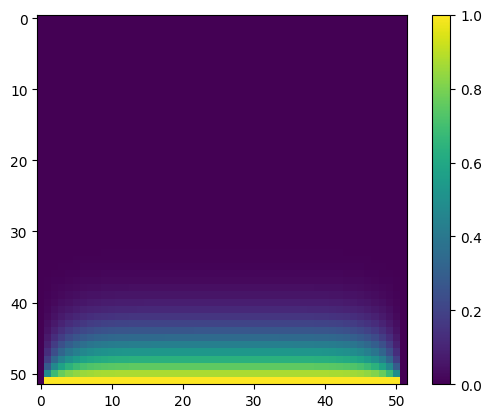

In [142]:
plt.imshow(grid[100])
plt.colorbar()

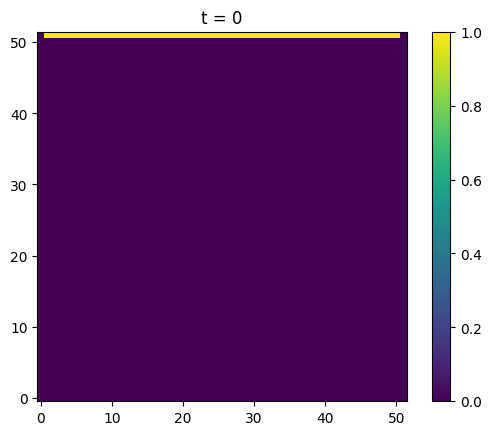

In [143]:
u = grid
fig, ax = plt.subplots()
im = ax.imshow(u[0], origin="lower", interpolation="nearest")
fig.colorbar(im, ax=ax)

def update(frame):
    im.set_data(u[frame])
    ax.set_title(f"t = {frame}")
    return [im]

anim = FuncAnimation(fig, update, frames=999, interval=50, blit=True)
plt.show()
anim.save("animation2.mp4", fps=30)

In [114]:
exp = np.load('dataNCN/exp5.npy', allow_pickle=True).item()

In [115]:
correct_grid = exp['NCV_grid']

In [116]:
c_grid = correct_grid[:,:,:,1]

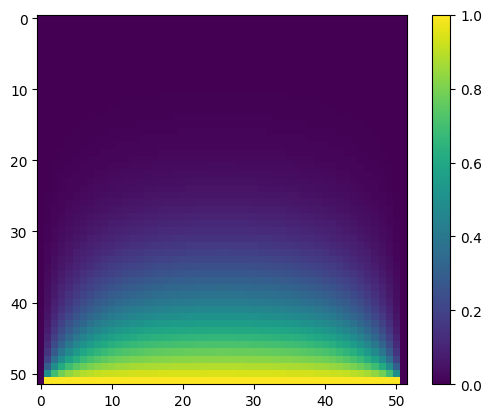

In [118]:
plt.imshow(c_grid[100])
plt.colorbar()

In [129]:
total_error = 0
error_list = []
for t in range(0,999):
    error = 0
    for i in range(1,N+1):
        for j in range(1,N+1):
            error += (grid[t,i,j] - c_grid[t,i,j])**2
    error_list.append(error)
    total_error+=error


C:\Users\umang\AppData\Local\Temp\ipykernel_3092\3924345133.py:7: RuntimeWarning: overflow encountered in scalar add
  error += (grid[t,i,j] - c_grid[t,i,j])**2
C:\Users\umang\AppData\Local\Temp\ipykernel_3092\3924345133.py:7: RuntimeWarning: overflow encountered in scalar power
  error += (grid[t,i,j] - c_grid[t,i,j])**2


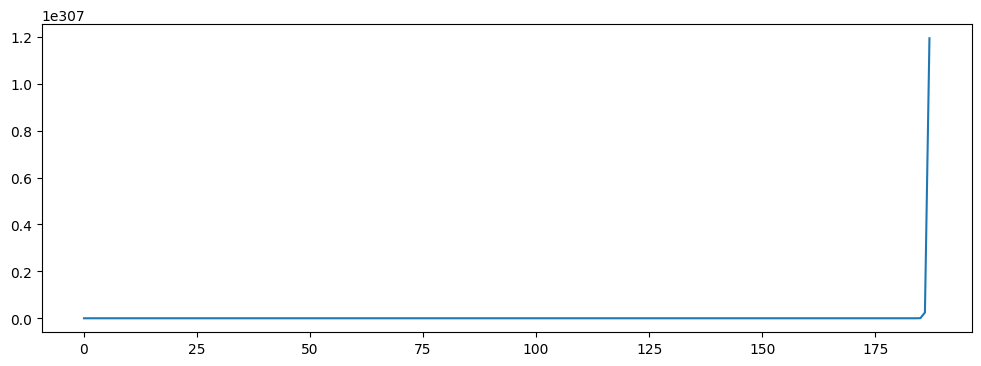

In [130]:

plt.figure(figsize=(12, 4))
plt.plot(error_list[:250])

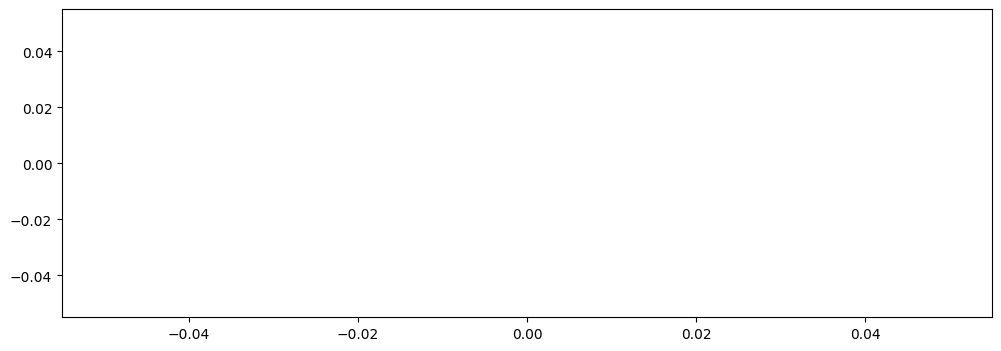

In [131]:
plt.figure(figsize=(12, 4))
plt.plot(error_list[250:500])

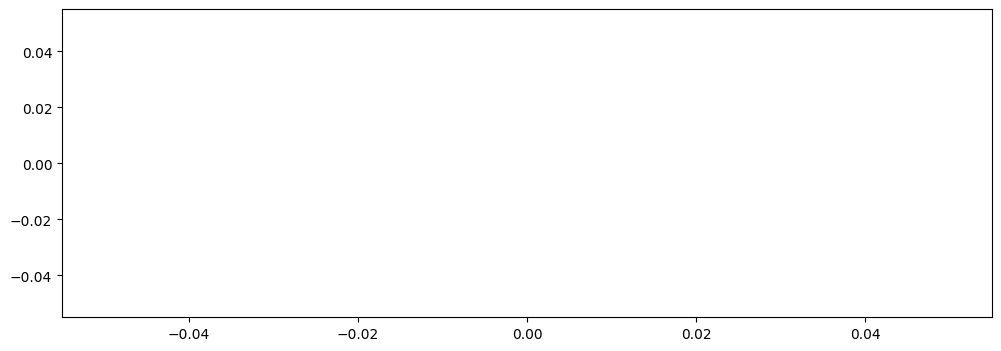

In [132]:
plt.figure(figsize=(12, 4))
plt.plot(error_list[500:750])

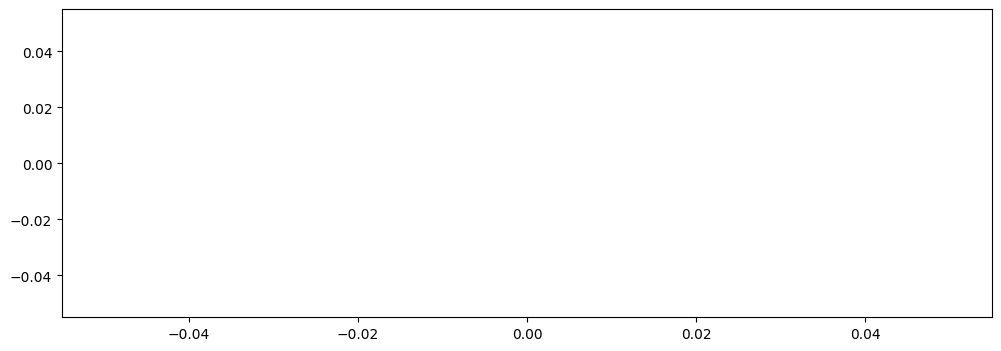

In [133]:
plt.figure(figsize=(12, 4))
plt.plot(error_list[750:999])